In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pickle

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#### The Medley Instruments Data Set

In [3]:
df = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata.csv')

In [4]:
df

,subset,instrument,instrument_id,song_id,uuid4
0,test,clarinet,0,0,0e4371ac-1c6a-51ab-fdb7-f8abd5fbf1a3
1,test,clarinet,0,0,33383119-fd64-59c1-f596-d1a23e8a0eff
2,test,clarinet,0,0,b2b7a288-e169-5642-fced-b509c06b11fc
3,test,clarinet,0,0,151b6ee4-313a-58d9-fbcb-bab73e0d426b
4,test,clarinet,0,0,b43999d1-9b5e-557f-f9bc-1b3759659858
...,...,...,...,...,...
21566,validation,violin,7,226,fe4e8e98-6e0f-5a31-f446-99c10e0ac485
21567,validation,violin,7,226,aa606c78-9ee5-507f-f7e9-67c3530faf0f
21568,validation,violin,7,226,05e15c0a-d530-5f3e-fa82-58c55fa44993
21569,validation,violin,7,226,2dd485de-471d-5d8b-fe92-ef957dac021c


In [5]:
df.nunique()

subset               3
instrument           8
instrument_id        8
song_id            227
uuid4            21571
dtype: int64

In [6]:
df['instrument'].unique()

array(['clarinet', 'distorted electric guitar', 'female singer', 'flute',
       'piano', 'tenor saxophone', 'trumpet', 'violin'], dtype=object)

In [7]:
df.groupby(['instrument']).count()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1311,1311,1311,1311
distorted electric guitar,1854,1854,1854,1854
female singer,1744,1744,1744,1744
flute,3555,3555,3555,3555
piano,6032,6032,6032,6032
tenor saxophone,477,477,477,477
trumpet,627,627,627,627
violin,5971,5971,5971,5971


In [8]:
df.groupby(['instrument']).count().sum()

subset           21571
instrument_id    21571
song_id          21571
uuid4            21571
dtype: int64

In [9]:
df['subset'].unique()

array(['test', 'training', 'validation'], dtype=object)

In [10]:
df.groupby(['subset']).count()

,instrument,instrument_id,song_id,uuid4
subset,,,,
test,12236,12236,12236,12236
training,5841,5841,5841,5841
validation,3494,3494,3494,3494


Splitting Dataframe into Train, Validation and Test Dataframes

In [11]:
df_train = df.loc[df['subset']=='training']

##### Read train, validation and test dataframes

In [12]:
df_train = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_training.csv',index_col=0)

In [13]:
df_val = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_validation.csv',index_col=0)

In [14]:
df_test = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_test.csv',index_col=0)

In [15]:
df_train.head()

,subset,instrument,instrument_id,song_id,uuid4
12236,training,clarinet,0,139,163fd2b1-8e98-515a-f501-4742cc6d066f
12237,training,clarinet,0,139,36dcb8eb-da46-5d01-fa9d-0f715c389379
12238,training,clarinet,0,139,9f6d4046-3662-5433-fc44-98c80a428fd8
12239,training,clarinet,0,139,5ef6a0ee-a092-5d49-f64e-a3454e9ab237
12240,training,clarinet,0,139,2048e98b-77b2-5b7d-fe6a-780f399e69fe


#### First  approach: model for two instruments

In [16]:
# processing approach:
# define dataframe_subset_instrument
# load into librosa .wav to audio array (n,)
# save arrays with numpy

In [17]:
# starting with the Train Set: 404 elements distorted guitar

In [18]:
# begin with two instruments

In [19]:
instruments = df_train['instrument'].unique()

In [20]:
df_train.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,5,251
distorted electric guitar,1,1,10,404
female singer,1,1,7,318
flute,1,1,3,155
piano,1,1,20,2401
tenor saxophone,1,1,2,123
trumpet,1,1,4,149
violin,1,1,10,2040


In [21]:
df_val.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,2,328
distorted electric guitar,1,1,4,495
female singer,1,1,4,284
flute,1,1,2,233
piano,1,1,8,1022
tenor saxophone,1,1,1,29
trumpet,1,1,2,72
violin,1,1,4,1031


In [22]:
df_test.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,18,732
distorted electric guitar,1,1,11,955
female singer,1,1,12,1142
flute,1,1,29,3167
piano,1,1,15,2609
tenor saxophone,1,1,5,325
trumpet,1,1,27,406
violin,1,1,22,2900


Understanding how the data: how many songs were used per class

In [23]:
df_train.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                             [139, 140, 141, 142, 143]
distorted electric guitar    [144, 145, 146, 147, 148, 149, 150, 151, 152, ...
female singer                              [154, 155, 156, 157, 158, 159, 160]
flute                                                          [161, 162, 163]
piano                        [164, 165, 166, 167, 168, 169, 170, 171, 172, ...
tenor saxophone                                                     [184, 185]
trumpet                                                   [186, 187, 188, 189]
violin                       [190, 191, 192, 193, 194, 195, 196, 197, 198, ...
Name: song_id, dtype: object

In [24]:
df_val.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                                   [200, 201]
distorted electric guitar                        [202, 203, 204, 205]
female singer                                    [206, 207, 208, 209]
flute                                                      [210, 211]
piano                        [212, 213, 214, 215, 216, 217, 218, 219]
tenor saxophone                                                 [220]
trumpet                                                    [221, 222]
violin                                           [223, 224, 225, 226]
Name: song_id, dtype: object

In [25]:
df_val.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                                   [200, 201]
distorted electric guitar                        [202, 203, 204, 205]
female singer                                    [206, 207, 208, 209]
flute                                                      [210, 211]
piano                        [212, 213, 214, 215, 216, 217, 218, 219]
tenor saxophone                                                 [220]
trumpet                                                    [221, 222]
violin                                           [223, 224, 225, 226]
Name: song_id, dtype: object

In [26]:
# smaller data frames

In [27]:
df_train_clarinet = df_train.loc[df_train['instrument_id']==0].set_index('subset').reset_index()

In [28]:
df_train_guitar = df_train.loc[df_train['instrument_id']==1].set_index('subset').reset_index()

In [29]:
df_train_singer = df_train.loc[df_train['instrument_id']==2].set_index('subset').reset_index()

In [30]:
df_train_singer.head(3)

,subset,instrument,instrument_id,song_id,uuid4
0,training,female singer,2,154,5fe4c1de-b6da-5b50-f4d6-ed9925fc0931
1,training,female singer,2,154,69cbbcff-834b-55c0-f7fe-4d809ebe34e3
2,training,female singer,2,154,94072b83-a4ae-57a9-f196-a74af1e5f3b0


In [31]:
df_train_guitar.shape

(404, 5)

In [32]:
df_train_singer.shape

(318, 5)

In [33]:
# with the validation subset

In [34]:
df_val_clarinet = df_val.loc[df_val['instrument_id']==0].set_index('subset').reset_index()

In [35]:
df_val_guitar = df_val.loc[df_val['instrument_id']==1].set_index('subset').reset_index()

In [36]:
df_val_singer = df_val.loc[df_val['instrument_id']==2].set_index('subset').reset_index()

In [37]:
# with the test subset

In [38]:
df_test_clarinet = df_test.loc[df_test['instrument_id']==0].set_index('subset').reset_index()

In [39]:
df_test_guitar = df_test.loc[df_test['instrument_id']==1].set_index('subset').reset_index()

In [40]:
df_test_singer = df_test.loc[df_test['instrument_id']==2].set_index('subset').reset_index()

#### Loading signal saved in .npy numpy array files

In [41]:
filename_pre = "Medley-solos-DB"

In [42]:
def load_amp_file(filename,df):
    """input: filename, for example: amp_tr_clarinet
    output: list of amplitude vectors
    """
    # load amplitude vector
    # the corresponding dataframe must be at hand
    n_elements=(len(df))
    folderpath="../../../../../../documents/data/audio/medley/audio_arrays/"
    amp_list=[]
    with open (folderpath+filename, 'rb') as f:
        for n in range(n_elements):
            amp_1 = np.load(f)
            amp_list.append(amp_1)
    return amp_list

In [43]:
amplitude_train_clarinet = load_amp_file('amp_tr_clarinet', df_train_clarinet)

In [44]:
amplitude_train_guitar = load_amp_file('amp_tr_guitar', df_train_guitar)

In [45]:
amplitude_train_singer = load_amp_file('amp_tr_singer', df_train_singer)

In [46]:
# it works!

In [47]:
# with the val dataframes

In [48]:
#load validation subset amplitude arrays

In [49]:
amplitude_val_clarinet = load_amp_file('amp_val_clarinet', df_val_clarinet)

In [50]:
amplitude_val_guitar = load_amp_file('amp_val_guitar', df_val_guitar)

In [51]:
amplitude_val_singer = load_amp_file('amp_val_singer', df_val_singer)

In [52]:
#with the test dataframes

In [53]:
#load test subset amplitude arrays

In [54]:
amplitude_test_clarinet = load_amp_file('amp_test_clarinet', df_test_clarinet)

In [55]:
amplitude_test_guitar = load_amp_file('amp_test_guitar', df_test_guitar)

In [56]:
amplitude_test_singer = load_amp_file('amp_test_singer', df_test_singer)

In [57]:
#benchmark

In [58]:
len(amplitude_train_clarinet), len(amplitude_train_guitar), len(amplitude_train_singer)

(251, 404, 318)

In [59]:
# correct!

In [60]:
len(amplitude_val_clarinet), len(amplitude_val_guitar), len(amplitude_val_singer)

(328, 495, 284)

In [61]:
# correct!

In [62]:
len(amplitude_test_clarinet), len(amplitude_test_guitar), len(amplitude_test_singer)

(732, 955, 1142)

In [63]:
# correct!

In [64]:
amplitude_test_clarinet[0].shape, amplitude_test_guitar[0].shape, amplitude_test_singer[0].shape

((65536,), (65536,), (65536,))

In [65]:
# it worked!

In [66]:
# up here: second part, load data and ML

MEL SPECTROGRAM

In [67]:
def amp_list_to_mel_list(amp_list):
    """input: list of signal arrays 1d
    output: list of melspectrogram arrays 2d"""
    mel_list=[]
    for amplitude_1 in amp_list:
        mel_spectrogram_1 = librosa.feature.melspectrogram(y=amplitude_1,n_mels=129)
        mel_list.append(mel_spectrogram_1)  
    return mel_list

In [68]:
## TRAINING SUBSET

In [69]:
mel_spectrogram_train_clarinet = amp_list_to_mel_list(amplitude_train_clarinet)

In [70]:
mel_spectrogram_train_guitar = amp_list_to_mel_list(amplitude_train_guitar)

In [71]:
mel_spectrogram_train_singer = amp_list_to_mel_list(amplitude_train_singer)

In [72]:
len(mel_spectrogram_train_clarinet), len(mel_spectrogram_train_guitar), len(mel_spectrogram_train_singer)

(251, 404, 318)

In [73]:
mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_singer[0].shape

((129, 129), (129, 129), (129, 129))

In [74]:
X_tr_clarinet = np.stack(mel_spectrogram_train_clarinet,axis=0)
X_tr_clarinet.shape

(251, 129, 129)

In [75]:
X_tr_guitar = np.stack(mel_spectrogram_train_guitar,axis=0)
X_tr_guitar.shape

(404, 129, 129)

In [76]:
y_tr_guitar = np.ones((404,1))

In [77]:
X_tr_guitar_resh = X_tr_guitar.reshape(404,129,129,1)

In [78]:
X_tr_singer = np.stack(mel_spectrogram_train_singer,axis=0)
X_tr_singer.shape

(318, 129, 129)

In [79]:
y_tr_singer = np.zeros((318,1))

In [80]:
X_tr_singer_resh = X_tr_singer.reshape(318,129,129,-1)

In [81]:
X_tr_singer_resh.shape

(318, 129, 129, 1)

In [82]:
# X_train shape (number wav files, f domain, t domain, 1)
# number wav guitar + singer = 404 +318 = 722
(722, 90, 129)

(722, 90, 129)

In [83]:
X_train = np.concatenate([X_tr_guitar_resh, X_tr_singer_resh])

In [84]:
X_train.shape

(722, 129, 129, 1)

In [85]:
y_train = np.concatenate([y_tr_guitar, y_tr_singer])

In [86]:
y_train.shape

(722, 1)

In [87]:
# One hot encode the labels:
# Keep a copy of y test as the actual number labels:
y_train_true = y_train.copy()

In [88]:
y_train = to_categorical(y_train)

In [89]:
y_train.shape

(722, 2)

In [90]:
## VALIDATION SUBSET

In [91]:
mel_spectrogram_val_clarinet = amp_list_to_mel_list(amplitude_val_clarinet)

In [92]:
mel_spectrogram_val_guitar = amp_list_to_mel_list(amplitude_val_guitar)

In [93]:
mel_spectrogram_val_singer = amp_list_to_mel_list(amplitude_val_singer)

In [94]:
len(mel_spectrogram_val_clarinet), len(mel_spectrogram_val_guitar), len(mel_spectrogram_val_singer)

(328, 495, 284)

In [95]:
mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_singer[0].shape

((129, 129), (129, 129), (129, 129))

In [96]:
# X_val, y val

In [97]:
# clarinet

In [98]:
X_val_clarinet = np.stack(mel_spectrogram_val_clarinet,axis=0)
X_val_clarinet.shape

(328, 129, 129)

In [99]:
# guitar

In [100]:
X_val_guitar = np.stack(mel_spectrogram_val_guitar,axis=0)
X_val_guitar.shape

(495, 129, 129)

In [101]:
X_val_guitar_resh = X_val_guitar.reshape(495,129,129,1)

In [102]:
y_val_guitar = np.ones((495,1))

In [103]:
# singer

In [104]:
X_val_singer = np.stack(mel_spectrogram_val_singer,axis=0)
X_val_singer.shape

(284, 129, 129)

In [105]:
X_val_singer_resh = X_val_singer.reshape(284,129,129,-1)

In [106]:
X_val_singer_resh.shape

(284, 129, 129, 1)

In [107]:
y_val_singer = np.zeros((284,1))

In [108]:
# X_val shape (number wav files, f domain, t domain, 1)
# number wav guitar + singer = 495 + 284 = 779
(779, 90, 129)

(779, 90, 129)

In [109]:
X_val = np.concatenate([X_val_guitar_resh, X_val_singer_resh])

In [110]:
X_val.shape

(779, 129, 129, 1)

In [111]:
y_val = np.concatenate([y_val_guitar, y_val_singer])

In [112]:
y_val.shape

(779, 1)

In [113]:
# One hot encode the labels:
# Keep a copy of y test as the actual number labels:
y_val_true = y_val.copy()

In [114]:
y_val = to_categorical(y_val)

In [115]:
y_val.shape

(779, 2)

In [116]:
# the same needs to be done with the test 

MODELLING

In [117]:
# general functions and plots

In [118]:
def plot_accuracy(history):    
    # Plot accuracy curve
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()

In [119]:
def plot_loss(history):
# Plot loss
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

In [120]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'
)

In [121]:
# Model

In [133]:
#model 00: relu, relu

In [163]:
# model 00
# Clear session and build above model:
K.clear_session()
model_00 = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(2,activation= 'sigmoid')   
])

In [164]:
# Check the summary:
model_00.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1440100   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [165]:
# compile model
model_00.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [166]:
# fit the model
history_00 = model_00.fit(X_train,y_train,batch_size=400, epochs=35,validation_data=(X_val,y_val))

Epoch 1/35
2/2 [==============================] - 8s 4s/step - loss: 1.1142 - accuracy: 0.4335 - val_loss: 2.3430 - val_accuracy: 0.5494
Epoch 2/35
2/2 [==============================] - 8s 4s/step - loss: 0.7254 - accuracy: 0.7147 - val_loss: 0.4735 - val_accuracy: 0.8331
Epoch 3/35
2/2 [==============================] - 8s 5s/step - loss: 0.3029 - accuracy: 0.8615 - val_loss: 0.3924 - val_accuracy: 0.8549
Epoch 4/35
2/2 [==============================] - 10s 6s/step - loss: 0.2936 - accuracy: 0.8947 - val_loss: 0.4082 - val_accuracy: 0.8549
Epoch 5/35
2/2 [==============================] - 10s 6s/step - loss: 0.2429 - accuracy: 0.9030 - val_loss: 0.3812 - val_accuracy: 0.8575
Epoch 6/35
2/2 [==============================] - 12s 7s/step - loss: 0.2140 - accuracy: 0.9100 - val_loss: 0.3661 - val_accuracy: 0.8575
Epoch 7/35
2/2 [==============================] - 11s 6s/step - loss: 0.2059 - accuracy: 0.9127 - val_loss: 0.3619 - val_accuracy: 0.8614
Epoch 8/35
2/2 [=====================

In [169]:
model_00.save('../data/models/two_instruments/2conv_00.h5')

In [147]:
# with open('../data/models/two_instruments/3conv2d_bn_dout_hist.h5', 'wb') as file_pi:
  #      pickle.dump(history.history, file_pi)

In [155]:
# history_2B_loaded = pickle.load(open('../data/models/two_instruments/3conv2d_bn_dout_hist.h5',"rb"))

In [480]:
# examine the model

In [170]:
history_00.history;

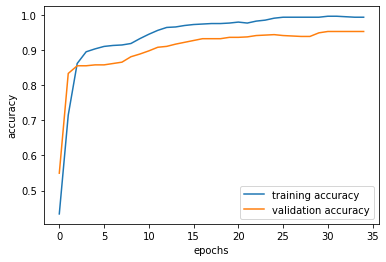

In [171]:
plot_accuracy(history_00)

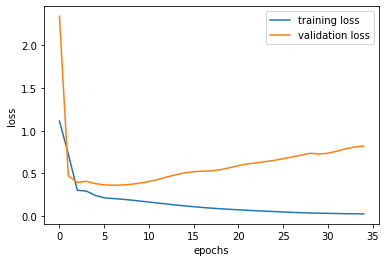

In [172]:
plot_loss(history_00)

<AxesSubplot:>

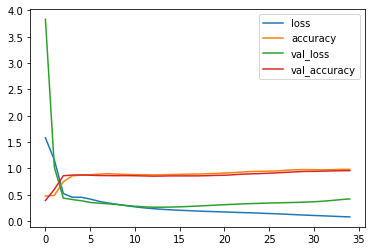

In [484]:
pd.DataFrame(history.history).plot()

In [122]:
# model 0a: relu / tanh

In [123]:
# model 0a
# Clear session and build above model:
K.clear_session()
model_0a = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(2,activation= 'sigmoid')   
])

In [124]:
# Check the summary:
model_0a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1440100   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [125]:
# compile model
model_0a.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [126]:
# fit the model
history_0a = model_0a.fit(X_train,y_train,batch_size=722,epochs=40,validation_data=(X_val,y_val),callbacks=[early_stop])

Epoch 1/40
1/1 [==============================] - 14s 14s/step - loss: 0.6947 - accuracy: 0.5886 - val_loss: 1.3684 - val_accuracy: 0.7741
Epoch 2/40
1/1 [==============================] - 10s 10s/step - loss: 0.8573 - accuracy: 0.8546 - val_loss: 0.1909 - val_accuracy: 0.9397
Epoch 3/40
1/1 [==============================] - 8s 8s/step - loss: 0.2477 - accuracy: 0.9183 - val_loss: 0.1386 - val_accuracy: 0.9833
Epoch 4/40
1/1 [==============================] - 8s 8s/step - loss: 0.2444 - accuracy: 0.9349 - val_loss: 0.1195 - val_accuracy: 0.9833
Epoch 5/40
1/1 [==============================] - 8s 8s/step - loss: 0.2139 - accuracy: 0.9432 - val_loss: 0.1105 - val_accuracy: 0.9795
Epoch 6/40
1/1 [==============================] - 8s 8s/step - loss: 0.1746 - accuracy: 0.9598 - val_loss: 0.1034 - val_accuracy: 0.9756
Epoch 7/40
1/1 [==============================] - 8s 8s/step - loss: 0.1516 - accuracy: 0.9709 - val_loss: 0.0903 - val_accuracy: 0.9743
Epoch 8/40
1/1 [=====================

In [165]:
model_0a.save('../data/models/two_instruments/2conv_0a.h5')

In [ ]:
# model_0a_loaded = keras.models.load_model('../data/models/three_instruments/2conv_0a.h5')

In [131]:
# save history

In [166]:
df_history_0a = pd.DataFrame(history_0a.history)
df_history_0a.to_csv('../data/models/two_instruments/2conv_0a_hist.csv')

In [188]:
# examine the model

In [167]:
history_0a.history;

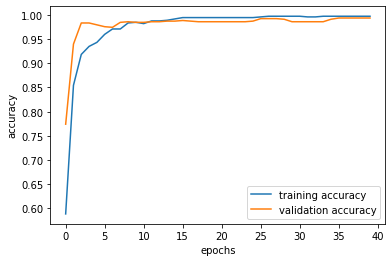

In [168]:
plot_accuracy(history_0a)
plt.savefig('../data/models/two_instruments/2conv_0a_acc.png')

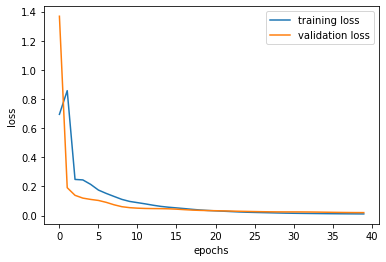

In [169]:
plot_loss(history_0a)
plt.savefig('../data/models/two_instruments/2conv_0a_loss.png')

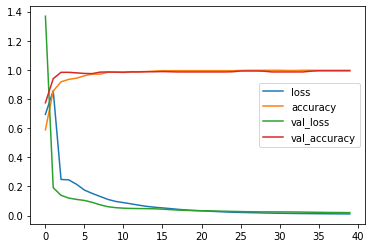

In [171]:
pd.DataFrame(history_0a.history).plot()
plt.savefig('../data/models/two_instruments/2conv_0a_acc_loss.png')

In [558]:
#model 0b: tanh / tanh

In [494]:
# model 00b:
# Clear session and build above model:
K.clear_session()
model = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'tanh' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(2,activation= 'sigmoid')   
])

In [495]:
# Check the summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1440100   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [496]:
# compile model
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [497]:
# fit the model
history = model.fit(X_train,y_train,batch_size=400, epochs=35,validation_data=(X_val,y_val))

Epoch 1/35
2/2 [==============================] - 9s 5s/step - loss: 0.6122 - accuracy: 0.6717 - val_loss: 0.3205 - val_accuracy: 0.9782
Epoch 2/35
2/2 [==============================] - 8s 5s/step - loss: 0.3162 - accuracy: 0.9488 - val_loss: 0.1181 - val_accuracy: 0.9820
Epoch 3/35
2/2 [==============================] - 8s 5s/step - loss: 0.1917 - accuracy: 0.9446 - val_loss: 0.0752 - val_accuracy: 0.9859
Epoch 4/35
2/2 [==============================] - 8s 5s/step - loss: 0.1504 - accuracy: 0.9598 - val_loss: 0.0732 - val_accuracy: 0.9897
Epoch 5/35
2/2 [==============================] - 8s 5s/step - loss: 0.1149 - accuracy: 0.9778 - val_loss: 0.0675 - val_accuracy: 0.9859
Epoch 6/35
2/2 [==============================] - 8s 5s/step - loss: 0.0865 - accuracy: 0.9889 - val_loss: 0.0454 - val_accuracy: 0.9949
Epoch 7/35
2/2 [==============================] - 8s 5s/step - loss: 0.0687 - accuracy: 0.9861 - val_loss: 0.0369 - val_accuracy: 0.9910
Epoch 8/35
2/2 [=========================

In [498]:
# examine the model

In [499]:
history.history;

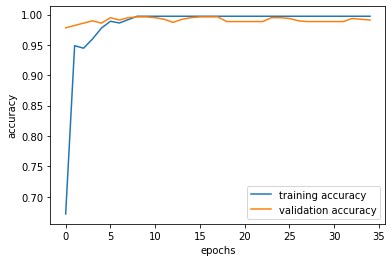

In [500]:
plot_accuracy(history)

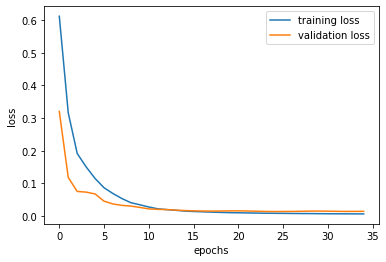

In [501]:
plot_loss(history)

<AxesSubplot:>

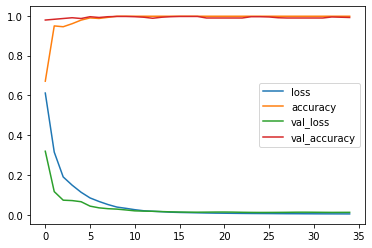

In [502]:
pd.DataFrame(history.history).plot()

In [444]:
# model 1:
# 2nd Conv2D with tanh
# bath norm after 1st Conv2D

In [435]:
# model 01
# Clear session and build above model:
K.clear_session()

model = Sequential([
    Conv2D( filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu', input_shape = (129,129,1)),
    
    BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(2,activation= 'sigmoid')   
])

In [436]:
# Check the summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [437]:
# compile model
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [438]:
# fit the model
history = model.fit(X_train,y_train,batch_size=722, epochs=40,validation_data=(X_val,y_val))

Epoch 1/40
1/1 [==============================] - 25s 25s/step - loss: 0.7103 - accuracy: 0.5526 - val_loss: 1.2289 - val_accuracy: 0.5597
Epoch 2/40
1/1 [==============================] - 12s 12s/step - loss: 0.5916 - accuracy: 0.8199 - val_loss: 0.9922 - val_accuracy: 0.6868
Epoch 3/40
1/1 [==============================] - 11s 11s/step - loss: 0.4661 - accuracy: 0.8102 - val_loss: 0.5612 - val_accuracy: 0.7882
Epoch 4/40
1/1 [==============================] - 11s 11s/step - loss: 0.3602 - accuracy: 0.8338 - val_loss: 0.3244 - val_accuracy: 0.8549
Epoch 5/40
1/1 [==============================] - 11s 11s/step - loss: 0.2735 - accuracy: 0.8864 - val_loss: 0.2553 - val_accuracy: 0.8845
Epoch 6/40
1/1 [==============================] - 12s 12s/step - loss: 0.2366 - accuracy: 0.8947 - val_loss: 0.2209 - val_accuracy: 0.8832
Epoch 7/40
1/1 [==============================] - 14s 14s/step - loss: 0.2272 - accuracy: 0.8892 - val_loss: 0.2015 - val_accuracy: 0.8883
Epoch 8/40
1/1 [===========

In [439]:
# examine the model

In [440]:
history.history

{'loss': [0.7102928161621094,
  0.5915521383285522,
  0.46605736017227173,
  0.36023715138435364,
  0.2735331654548645,
  0.23657630383968353,
  0.22715997695922852,
  0.21755477786064148,
  0.19943667948246002,
  0.1776445508003235,
  0.1599760353565216,
  0.1502484828233719,
  0.14501953125,
  0.13754266500473022,
  0.12373313307762146,
  0.10774195194244385,
  0.09577322751283646,
  0.08970073610544205,
  0.08461058884859085,
  0.07309868931770325,
  0.06010059267282486,
  0.04798433184623718,
  0.04286786913871765,
  0.037595514208078384,
  0.030170893296599388,
  0.028065519407391548,
  0.02344105765223503,
  0.023425672203302383,
  0.025363588705658913,
  0.023249272257089615,
  0.017376285046339035,
  0.017582999542355537,
  0.017812838777899742,
  0.015620216727256775,
  0.012962223961949348,
  0.011994244530797005,
  0.012042541056871414,
  0.011901984922587872,
  0.010658292099833488,
  0.009288571774959564],
 'accuracy': [0.5526315569877625,
  0.8199446201324463,
  0.8102493

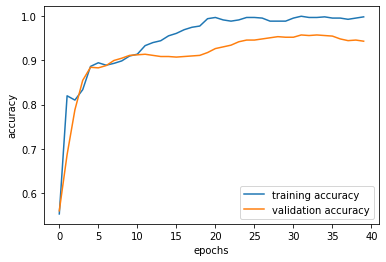

In [441]:
# Plot accuracy curve
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

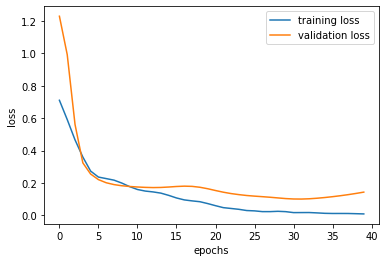

In [442]:
# Plot loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

<AxesSubplot:>

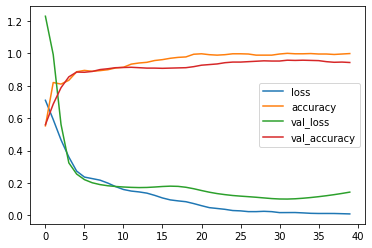

In [443]:
pd.DataFrame(history.history).plot()

In [559]:
# model 2
# 3 Conv2D

In [560]:
# model 02
# Clear session and build above model:
K.clear_session()

model = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(2,activation= 'sigmoid')   
])

In [561]:
# Check the summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [562]:
# compile model
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [563]:
# fit the model
history = model.fit(X_train,y_train,batch_size=400, epochs=30,validation_data=(X_val,y_val),callbacks = [early_stop])

Epoch 1/30
2/2 [==============================] - 12s 7s/step - loss: 0.6582 - accuracy: 0.7313 - val_loss: 0.4065 - val_accuracy: 0.9487
Epoch 2/30
2/2 [==============================] - 8s 5s/step - loss: 0.4493 - accuracy: 0.8823 - val_loss: 0.1967 - val_accuracy: 0.9756
Epoch 3/30
2/2 [==============================] - 8s 5s/step - loss: 0.3177 - accuracy: 0.8767 - val_loss: 0.1435 - val_accuracy: 0.9769
Epoch 4/30
2/2 [==============================] - 8s 5s/step - loss: 0.2330 - accuracy: 0.9377 - val_loss: 0.1037 - val_accuracy: 0.9833
Epoch 5/30
2/2 [==============================] - 9s 6s/step - loss: 0.1731 - accuracy: 0.9501 - val_loss: 0.0644 - val_accuracy: 0.9897
Epoch 6/30
2/2 [==============================] - 9s 5s/step - loss: 0.1346 - accuracy: 0.9529 - val_loss: 0.0633 - val_accuracy: 0.9961
Epoch 7/30
2/2 [==============================] - 8s 5s/step - loss: 0.1012 - accuracy: 0.9917 - val_loss: 0.0617 - val_accuracy: 0.9949
Epoch 8/30
2/2 [========================

In [564]:
model.save('../data/models/two_instruments/3conv2d.h5')

In [565]:
# examine the model

In [566]:
history.history;

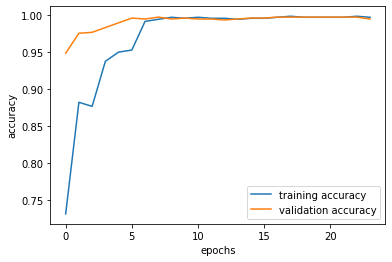

In [567]:
plot_accuracy(history)

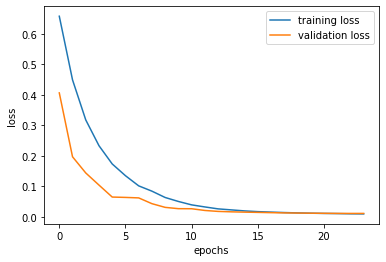

In [568]:
plot_loss(history)

<AxesSubplot:>

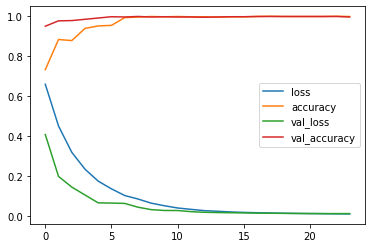

In [569]:
pd.DataFrame(history.history).plot()

In [602]:
new_model = keras.models.load_model('../data/models/two_instruments/3conv2d.h5')

In [606]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [608]:
print(new_model.history)

None


FINAL MODEL FOR 2-Instrumention: 3 Conv2D with batch norm & dropout

In [140]:
# model 2B
# 3 Conv2D with batch norm & dropout

In [141]:
# model 2B
# Clear session and build above model:
K.clear_session()

model_2B = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    
    BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Dropout(0.2),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Dropout(0.2),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Dropout(0.2),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    Dropout(0.2),
    Dense(2,activation= 'sigmoid')   
])

In [142]:
# Check the summary:
model_2B.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0

In [143]:
# compile model
model_2B.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [144]:
# fit the model
history_2B = model_2B.fit(X_train,y_train,batch_size=700, epochs=40,validation_data=(X_val,y_val))

Epoch 1/40
2/2 [==============================] - 23s 4s/step - loss: 1.2165 - accuracy: 0.5582 - val_loss: 0.6639 - val_accuracy: 0.4891
Epoch 2/40
2/2 [==============================] - 15s 3s/step - loss: 1.8113 - accuracy: 0.4446 - val_loss: 0.6014 - val_accuracy: 0.7689
Epoch 3/40
2/2 [==============================] - 15s 4s/step - loss: 0.7122 - accuracy: 0.5443 - val_loss: 0.5882 - val_accuracy: 0.8729
Epoch 4/40
2/2 [==============================] - 15s 3s/step - loss: 0.5271 - accuracy: 0.7701 - val_loss: 0.5707 - val_accuracy: 0.9140
Epoch 5/40
2/2 [==============================] - 15s 3s/step - loss: 0.5892 - accuracy: 0.6911 - val_loss: 0.5494 - val_accuracy: 0.9243
Epoch 6/40
2/2 [==============================] - 15s 3s/step - loss: 0.5273 - accuracy: 0.7244 - val_loss: 0.5241 - val_accuracy: 0.9371
Epoch 7/40
2/2 [==============================] - 15s 3s/step - loss: 0.4139 - accuracy: 0.8587 - val_loss: 0.4928 - val_accuracy: 0.9409
Epoch 8/40
2/2 [==================

In [158]:
model_2B.save('../data/models/two_instruments/3conv_2B.h5')

In [174]:
# model_2b_loaded = keras.models.load_model('../data/models/two_instruments/3conv2d_2B.h5')

In [176]:
# with open('../data/models/two_instruments/3conv2d_2B_hist.h5', 'wb') as file_pi:
        #pickle.dump(history_2B.history, file_pi)

In [177]:
# history_2B_loaded = pickle.load(open('../data/models/two_instruments/3conv2d_2B_hist.h5',"rb"))

In [ ]:
# history_2B_loaded

In [ ]:
# model_0a_loaded = keras.models.load_model('../data/models/three_instruments/2conv_0a.h5')

In [131]:
# save history

In [159]:
df_history_2B = pd.DataFrame(history_2B.history)
df_history_2B.to_csv('../data/models/two_instruments/3conv_2B_hist.csv')

In [188]:
# examine the model

In [160]:
history_2B.history;

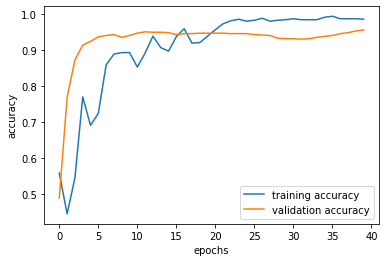

In [161]:
plot_accuracy(history_2B)
plt.savefig('../data/models/two_instruments/3conv_2B_acc.png')

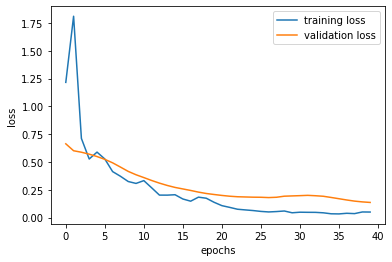

In [163]:
plot_loss(history_2B)
plt.savefig('../data/models/two_instruments/3conv_2B_loss.png')

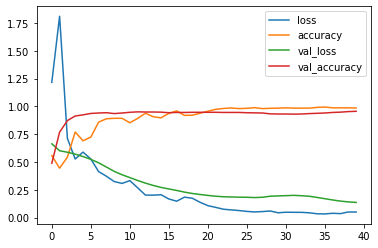

In [164]:
pd.DataFrame(history_2B.history).plot()
plt.savefig('../data/models/two_instruments/3conv_2B_acc_loss.png')

In [627]:
# predictions:

In [629]:
y_val.shape

(779, 2)

In [152]:
X_val[0].reshape(1,129,129,1).shape

(1, 129, 129, 1)

In [155]:
y_pred = model_2B.predict(X_val[1].reshape(1,129,129,1))

In [156]:
y_pred

array([[0.46128115, 0.44994277]], dtype=float32)

In [ ]:
X_test_guitar, X_test_singer, X_clarinet

In [ ]:
# model 03: more filters

In [ ]:
BENCHMARK

In [121]:
# model 2B
# 3 Conv2D with batch norm & dropout

In [123]:
# model 2B
# Clear session and build above model:
K.clear_session()

model_2B_BENCH = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    
    BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Dropout(0.2),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Dropout(0.2),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Dropout(0.2),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    Dropout(0.2),
    Dense(2,activation= 'sigmoid')   
])

In [125]:
# Check the summary:
model_2B_BENCH.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0

In [128]:
# compile model
model_2B_BENCH.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [129]:
# fit the model
history_2B = model_2B_BENCH.fit(X_train,y_train,batch_size=700, epochs=40,validation_data=(X_val,y_val),callbacks=[early_stop])

Epoch 1/40
2/2 [==============================] - 33s 9s/step - loss: 0.9663 - accuracy: 0.4889 - val_loss: 0.7103 - val_accuracy: 0.6277
Epoch 2/40
2/2 [==============================] - 14s 3s/step - loss: 2.0295 - accuracy: 0.5596 - val_loss: 0.6144 - val_accuracy: 0.8729
Epoch 3/40
2/2 [==============================] - 15s 3s/step - loss: 0.6191 - accuracy: 0.7673 - val_loss: 0.5536 - val_accuracy: 0.9037
Epoch 4/40
2/2 [==============================] - 14s 3s/step - loss: 0.5074 - accuracy: 0.8241 - val_loss: 0.5181 - val_accuracy: 0.9422
Epoch 5/40
2/2 [==============================] - 14s 3s/step - loss: 0.5023 - accuracy: 0.8075 - val_loss: 0.4851 - val_accuracy: 0.9461
Epoch 6/40
2/2 [==============================] - 13s 3s/step - loss: 0.4307 - accuracy: 0.8490 - val_loss: 0.4501 - val_accuracy: 0.9525
Epoch 7/40
2/2 [==============================] - 13s 3s/step - loss: 0.3863 - accuracy: 0.8490 - val_loss: 0.4171 - val_accuracy: 0.9525
Epoch 8/40
2/2 [==================

In [133]:
history_2B_BENCH = history_2B

In [131]:
model_2B_BENCH.save('../data/models/two_instruments/3conv2d_2B_BENCH.h5')

In [134]:
with open('../data/models/two_instruments/3conv2d_2B_BENCH_hist.h5', 'wb') as file_pi:
        pickle.dump(history_2B_BENCH.history, file_pi)

In [135]:
history_2B_BENCH_loaded = pickle.load(open('../data/models/two_instruments/3conv2d_2B_hist.h5',"rb"))

In [136]:
history_2B_BENCH_loaded;

In [137]:
history_2B_BENCH

In [138]:
history_2B_BENCH.history

{'loss': [0.9662976264953613,
  2.0294761657714844,
  0.6191309690475464,
  0.5073844790458679,
  0.5023183822631836,
  0.43069469928741455,
  0.38626742362976074,
  0.3245984613895416,
  0.29917633533477783,
  0.25617605447769165,
  0.23350392282009125,
  0.22660288214683533,
  0.18903684616088867,
  0.2018834948539734,
  0.17254365980625153,
  0.14721132814884186,
  0.15068714320659637,
  0.13640201091766357,
  0.1296176165342331],
 'accuracy': [0.4889196753501892,
  0.559556782245636,
  0.7673130035400391,
  0.8240997195243835,
  0.807479202747345,
  0.8490304946899414,
  0.8490304946899414,
  0.8836565017700195,
  0.8975069522857666,
  0.930747926235199,
  0.9182825684547424,
  0.9099723100662231,
  0.9362881183624268,
  0.9127423763275146,
  0.9376731514930725,
  0.9515235424041748,
  0.9432132840156555,
  0.9515235424041748,
  0.9570637345314026],
 'val_loss': [0.7103398442268372,
  0.614352285861969,
  0.5535536408424377,
  0.5180885791778564,
  0.48511818051338196,
  0.45009964

In [142]:
# examine the model

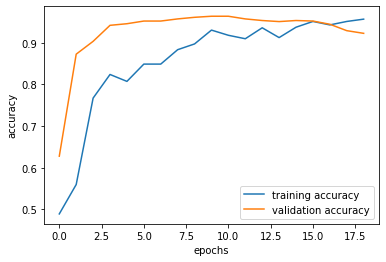

In [143]:
plot_accuracy(history_2B_BENCH)
plt.savefig('plot_2b_BENCH.png')

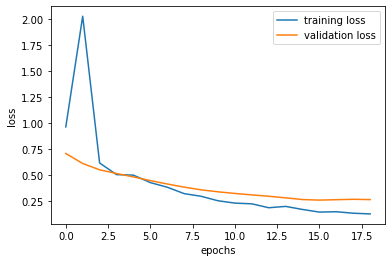

In [140]:
plot_loss(history_2B_BENCH)

<AxesSubplot:>

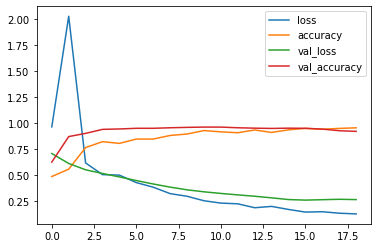

In [142]:
pd.DataFrame(history_2B_BENCH.history).plot()

In [504]:
# model 03
# Clear session and build above model:
K.clear_session()

model = Sequential([
    Conv2D( filters = 25, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu', input_shape = (129,129,1)),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Conv2D(filters = 25, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(2,activation= 'sigmoid')   
])

In [505]:
# Check the summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 25)      250       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 25)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 25)        5650      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 25)        0         
_________________________________________________________________
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2250100   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [507]:
# compile model
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [508]:
# fit the model
history = model.fit(X_train,y_train,batch_size=722, epochs=40,validation_data=(X_val,y_val))

Epoch 1/40
1/1 [==============================] - 47s 47s/step - loss: 0.7406 - accuracy: 0.2909 - val_loss: 0.7754 - val_accuracy: 0.7484
Epoch 2/40
1/1 [==============================] - 36s 36s/step - loss: 0.4155 - accuracy: 0.8393 - val_loss: 0.1580 - val_accuracy: 0.9641
Epoch 3/40
1/1 [==============================] - 27s 27s/step - loss: 0.3513 - accuracy: 0.8407 - val_loss: 0.1151 - val_accuracy: 0.9782
Epoch 4/40
1/1 [==============================] - 25s 25s/step - loss: 0.2143 - accuracy: 0.9294 - val_loss: 0.1192 - val_accuracy: 0.9679
Epoch 5/40
1/1 [==============================] - 28s 28s/step - loss: 0.1709 - accuracy: 0.9557 - val_loss: 0.1304 - val_accuracy: 0.9538
Epoch 6/40
1/1 [==============================] - 26s 26s/step - loss: 0.1656 - accuracy: 0.9474 - val_loss: 0.1112 - val_accuracy: 0.9692
Epoch 7/40
1/1 [==============================] - 21s 21s/step - loss: 0.1420 - accuracy: 0.9640 - val_loss: 0.0836 - val_accuracy: 0.9820
Epoch 8/40
1/1 [===========

In [514]:
# examine the model

In [515]:
history.history;

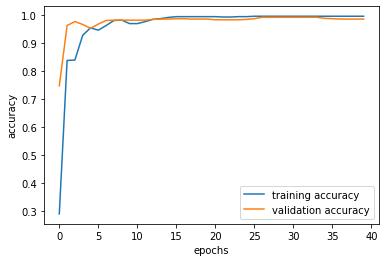

In [510]:
plot_accuracy(history)

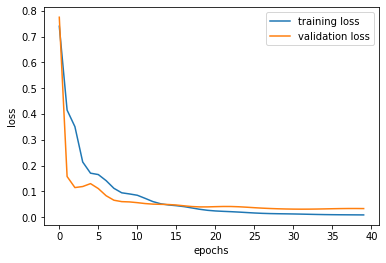

In [511]:
plot_loss(history)

<AxesSubplot:>

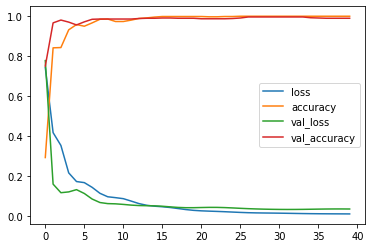

In [512]:
pd.DataFrame(history.history).plot()

In [388]:
# confusion matrix

#### Pre trained CNN

In [1]:
# bonus: shuffling an array

In [16]:
abc = np.array([[1,2],[3,4],[5,6],[7,8],[0,9]])

In [17]:
abc

array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8],
       [0, 9]])

In [18]:
abc.shape

(5, 2)

In [61]:
np.random.shuffle(abc)
abc

array([[7, 8],
       [3, 4],
       [5, 6],
       [1, 2],
       [0, 9]])

In [10]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])